In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import geopandas as gpd
import pyriv
from IPython.display import Markdown

Populating the interactive namespace from numpy and matplotlib


Coastline poly creation discussed [here](Overview.ipynb).

In [2]:
coast = gpd.read_file('/home/shares/scientist/pyriv/shapefiles/SASAP_Coastline_Polygon.shp')

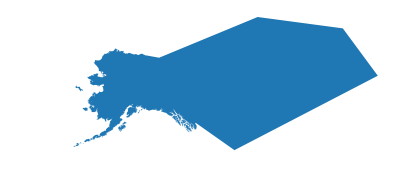

In [3]:
ax = coast.plot()
ax.set_axis_off()

In [4]:
vert_list = pyriv.coastal.coords_from_coastline(coast)
len(vert_list)

89510

In [5]:
coast_simp = coast.set_geometry(coast.simplify(500))
vert_list_simp = pyriv.coastal.coords_from_coastline(coast_simp)
len(vert_list_simp)

13454

When I did the [east coast network](../EC_RiverHerring/aFull_Network_Prep.ipynb), I simplified down to about 7k verticies and it still took around 5 hours to generate the network using 20 processors. The time it takes should increase basically exponentially with the number of verticies, so I don't really want to try with 13.5k. I'll try to simplify it some more.

In [6]:
coast_simp = coast.set_geometry(coast.simplify(1000).buffer(0))
vert_list_simp = pyriv.coastal.coords_from_coastline(coast_simp)
len(vert_list_simp)

7623

Okay, I'll try 1km simplification. Here's the code I'll use to build the network:

In [7]:
with open('SASAP_Coast_Build.py', 'r') as myfile:
    code = myfile.read()
Markdown("```python \n" + code + "\n```")

```python 
import pandas as pd
import geopandas as gpd
import os
from pyriv.coastal import Land
import networkx as nx

## Setup: ######
data_dir = '/home/shares/scientist/pyriv/shapefiles/'
fullpath = lambda s: os.path.join(data_dir, s)
full_land_fn = fullpath('SASAP_Coastline_Polygon.shp')
simp_num = 1000
n_processors = 38

land_out_fn = fullpath('SASAP_coast_poly{}m.shp'.format(simp_num))
gpic_out_fn = fullpath('SASAP_coast{}m.gpickle'.format(simp_num))

# read in the full resolution land shapefile
full_land = gpd.read_file(full_land_fn)
# dump small polygons and simplify the remains
lowres_land = full_land.set_geometry(full_land.simplify(simp_num).buffer(0))
lowres_land.to_file(land_out_fn)
# generate the graph
lnd = Land(land_out_fn)
ecgraph = lnd.graph(n_jobs=n_processors)
nx.write_gpickle(ecgraph, gpic_out_fn)
```

This is run with the command:

`python SASAP_Coast_Build.py &`

## Join River Network

In [8]:
from pyriv import rg_light as rgl
import networkx as nx
import pandas as pd
import geopandas as gpd
import mplleaflet
import os
import pickle
from shapely.geometry import Point, LinearRing, Polygon, LineString

data_dir = '/home/shares/scientist/pyriv/shapefiles/'
fp = lambda s: os.path.join(data_dir, s)
gdf_from_geoms = lambda gs: gpd.GeoDataFrame({'geometry': gs})
def gdf_merge(gdf_list):
    gdf = gpd.GeoDataFrame( pd.concat(gdf_list, ignore_index=True) )
    gdf.crs = gdf_list[0].crs
    return gdf

In [9]:
print "NetworkX version: {}, Pandas version: {}, GeoPandas version: {}".format(nx.__version__, pd.__version__, gpd.__version__)

NetworkX version: 1.11, Pandas version: 0.22.0, GeoPandas version: 0.3.0


In [10]:
[fn for fn in os.listdir(data_dir) if os.path.splitext(fn)[1] in ('.shp','.gpickle')]

['SASAP_coast_poly500m.shp',
 'sasap_rivs_connected.shp',
 'SASAP_coast_poly1000m.shp',
 'SASAP_coast_poly3000m.shp',
 'SASAP_Coastline_Polygon.shp',
 'deadends_500m.shp',
 'SASAP_coast3000m.gpickle',
 'SASAP_coast1000m.gpickle',
 'SASAP_coast_poly2000m.shp']

In [11]:
lndfn = fp('SASAP_coast_poly1000m.shp')
lndnxfn = fp('SASAP_coast1000m.gpickle')

In [12]:
lnddf = gpd.read_file(lndfn)

Read in streams to rivergraph so I can find river ends (mouths and deadends).

In [71]:
%%time
# str_gr = nx.read_shp(fp('sasap_rivs_connected.shp'))
rgr = rgl.RiverGraph(data=fp('sasap_rivs_connected.shp'), coastline=lnddf)

CPU times: user 41.2 s, sys: 1.76 s, total: 43 s
Wall time: 43 s


In [72]:
dends = rgr.deadends()

In [73]:
len(dends)

2285

In [76]:
len(rgr.river_mouths)

56

In [78]:
rgr.riv_mouth_buffer = 1000

In [79]:
len(rgr.river_mouths)

56

In [80]:
rgr.delete_cache()
len(rgr.river_mouths)

2147

In [70]:
rgr.deadend_gdf(1000).is_coastal.sum()

2147

In [54]:
dedf = rgr.deadend_gdf(1000)

In [55]:
onland = dedf.within(lnddf.unary_union)

In [56]:
dedf['onland'] = onland.map({True: 'land', False: 'water'})

In [57]:
dedf.drop("is_coastal", axis='columns').to_file(fp('deadends_1000m.shp'))

In [58]:
dedf.head()

,geometry,is_coastal,end_type,onland
0,POINT (-379860.3187583779 1922551.521588362),True,Coastal,land
1,POINT (1070453.9823073 1055712.294317043),True,Coastal,water
2,POINT (-678731.9106695992 586245.4047647446),True,Coastal,water
3,POINT (-108358.3656240352 842225.6561565663),True,Coastal,land
4,POINT (-54362.78303254677 892811.0564870107),True,Coastal,land


In [59]:
rgrrms = rgr.river_mouths

In [60]:
len(rgrrms)

56

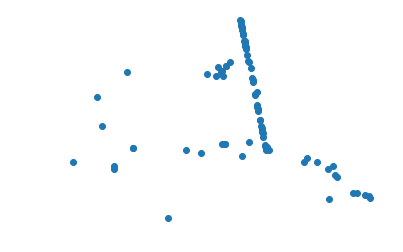

In [49]:
ax = dedf.query("end_type=='Inland' & onland=='land'").plot()
ax.set_axis_off()

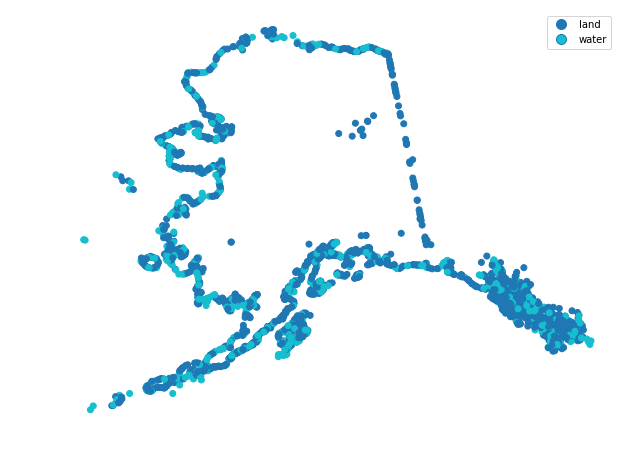

In [160]:
figsize(10,10)
ax = dedf.plot(column="onland", legend=True)
ax.set_axis_off()

In [150]:
rivs = gpd.read_file(fp('sasap_rivs_connected.shp'))

In [152]:
ax = dedf.to_crs(epsg=4326).plot(column="end_type")
mplleaflet.display()

In [34]:
lnddf.geom_type.apply(lambda s: s.find("Polygon") >= 0).all()

True

In [28]:
mpstr = "MultiPolygon"

In [29]:
mpstr.find("Polygon")

5

In [56]:
mg = lnddf.iloc[15].geometry

In [74]:
np.array(g.exterior.coords)

array([[1064469.79014394, 1041627.47158618],
       [1065572.29490892, 1039981.64899682],
       [1064369.63189756, 1039597.9102316 ],
       [1068916.77417452, 1039635.7513636 ],
       [1068739.43709374, 1036404.5755888 ],
       [1066170.29122742, 1035676.39399019],
       [1062906.04652861, 1037046.74144347],
       [1060679.61727135, 1033399.51825539],
       [1059752.415782  , 1033757.71193583],
       [1058344.40654808, 1033053.78394162],
       [1060983.84233072, 1032897.90971574],
       [1063344.10052966, 1034559.66202747],
       [1068237.54778724, 1033758.73226154],
       [1068713.3558677 , 1030896.32746351],
       [1069989.54675856, 1032467.8415151 ],
       [1068825.19791725, 1035122.80836428],
       [1072067.73631324, 1038074.48348926],
       [1072110.39601814, 1045547.07750193],
       [1074680.03768234, 1047238.12390876],
       [1074448.27014443, 1049440.62561926],
       [1075277.11383105, 1048325.27325568],
       [1077455.59408702, 1050403.07426317],
       [10

In [41]:
g = lnddf.iloc[1].geometry

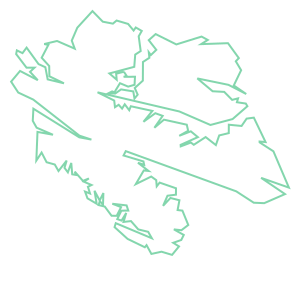

In [106]:
LineString(g.exterior.coords)

In [47]:
lnddf.geometry.apply(lambda g: LineString(g.exterior.coords))

AttributeError: 'MultiPolygon' object has no attribute 'exterior'

In [48]:
ccoords = pyriv.coastal.coords_from_coastline(lnddf)

In [50]:
len(ccoords)

7623

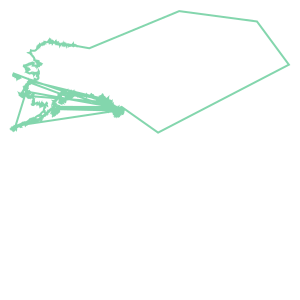

In [51]:
LineString(ccoords)

In [86]:
import itertools
len(rgr)

423791

In [92]:
rgr.graph.keys()

['coastline']

In [100]:
cps = nx.weakly_connected_component_subgraphs(nx.DiGraph(rgr))

In [101]:
for cp in itertools.islice(cps, 20):
    cp = rgl.RiverGraph(data=cp, coastline=rgr.coastline)
    print has_rivermouth(cp.nodes(), rgr)

AttributeError: 'str' object has no attribute 'apply'

In [102]:
type(rgr.coastline)

shapely.geometry.multilinestring.MultiLineString